In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal
import pandas as pd
from sklearn.metrics import roc_curve

# Part 1: Rejection Sampling on GMM

In [97]:
def rejection(N, p, q, k):
    samples = []

    for i in range(N):
        z = np.random.normal(5, 2)
        u = np.random.uniform(0, k * q(z)) # generate a u to compare with  
        
        if u <= p(z): # append the samples that aren't rejected
            samples.append(z)

    return np.array(samples) # return the samples that are kept

In [109]:
Zp = 3
mu = np.array([1,2,3])
sigma = np.array([0.1, 0.3, 0.2])
z_axis = np.linspace(-1, 5, 1000)

def p(z): 
    return sum([norm.pdf(z, mu[i], sigma[i]) for i in range(Zp)]) / Zp
def q(z):
    return norm.pdf(z, 2, 1)        # proposed distribution

k = max(p(z_axis)/q(z_axis))        # constant k st k*q(z) >= p(z) for all z

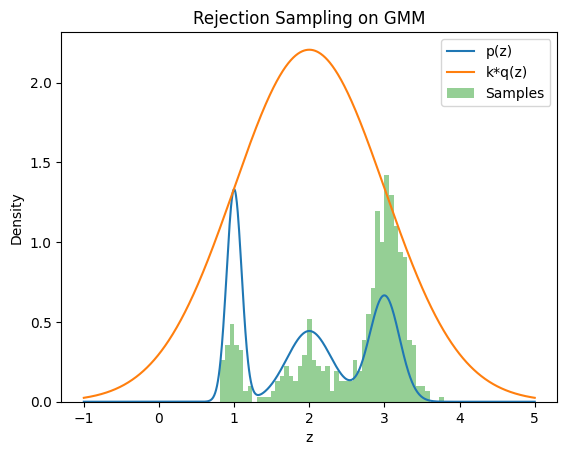

In [114]:
plt.plot(z_axis, p(z_axis), label='p(z)')           # target function
plt.plot(z_axis, k*q(z_axis), label='k*q(z)')       # comparison function

accepted = rejection(10000, p, q, k)                # rejection sampling

bins = np.linspace(-1, 5, 100)
plt.hist(accepted, bins, density=True, alpha=0.5, label='Samples')
plt.legend()
plt.title('Rejection Sampling on GMM')
plt.xlabel('z')
plt.ylabel('Density')
plt.show()

# Part 2:  Markov Chain Monte Carlo (MCMC)

In [162]:
# Generating Project 2 data

def generate_data(a_0, a_1, noise_sigma, X):
    N = len(X)
    noise = np.random.normal(0, noise_sigma, N)
    y = a_0 + a_1 * X + noise
    return y

a_0 = -0.3
a_1 = 0.5   
noise_sigma = 0.2
beta = 1/noise_sigma**2
std = np.sqrt(1/beta)

size = 25

alpha = 2.0
m0 = np.array([0, 0])
S0 = (1/alpha) * np.eye(2)

X = np.random.uniform(-1, 1, size)
y = generate_data(a_0, a_1, noise_sigma, X)

In [177]:
# using log likelihoods and priors gave a better result 
# than using the likelihoods and priors directly 

def likelihood(w):
    return np.sum(np.log(norm.pdf(y, w[0] + w[1]*X, std)))

def prior(w):      
    return np.log(norm(0.5, 0.5).pdf(w[0])) + np.log(norm(0.5, 0.5).pdf(w[1]))

def posterior(w):
    return likelihood(w) + prior(w)

def proposal(w): #proposal distribution based off normal distribution 
    return [np.random.normal(w[0], 0.5), np.random.normal(w[1], 0.5)]

In [182]:
# metropolis-hastings algorithm
def metropolis(N, proposal, posterior, w):
    samples = [w]
    for i in range(N):
        w_new = proposal(w)
        p = posterior(w_new) - posterior(w)
        if np.log(np.random.uniform(0, 1)) < p:
            w = w_new
        samples.append(w)
    return np.array(samples)
    
samples = metropolis(5000, proposal, posterior, [0, 1])


w0 mean: -0.22396193535814923, w1 mean: 0.4481242565776298


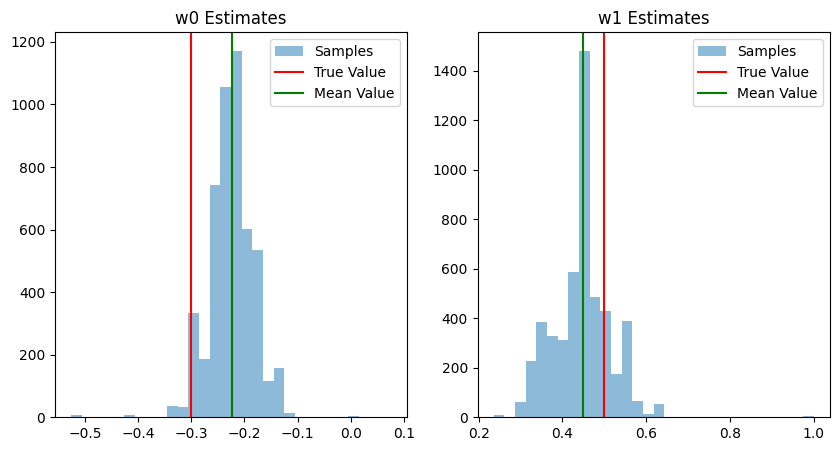

In [183]:
# plot estimates of w0 and w1

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

axs = ax.flatten()

truth = [a_0, a_1]

for i in range(2):
    axs[i].hist(samples[:, i], bins=30, alpha=0.5, label='Samples')
    axs[i].set_title(f'w{i} Estimates')
    axs[i].axvline(truth[i], color='r', label='True Value')
    axs[i].axvline(np.mean(samples[:, i]), color='g', label='Mean Value')
    axs[i].xlim = (truth[i]-0.1, truth[i]+0.1)
    axs[i].legend()

print(f'w0 mean: {np.mean(samples[:, 0])}, w1 mean: {np.mean(samples[:, 1])}')
plt.show()